In [1]:
from himalaya.ridge import RidgeCV
import numpy as np
from pathlib import Path
from AOTaccess.stimulus_info_access import StimuliInfoAccess
from AOTaccess.glmsingle_access import GLMSingleAccess

from himalaya.backend import set_backend

backend = set_backend("numpy", on_error="warn")

from AOTanalysis.bandedRR.utils import (
    reshape_from_flatten_masked_to_wholebrain,
)
from AOTanalysis.voxelsemantic.corpus_construct import construct_AOT_corpus
import joblib
import pickle
from pprint import pprint

import matplotlib.pyplot as plt
import random
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from nibabel import Nifti1Image
import cortex
import nibabel as nib


from matplotlib.colors import Normalize
def Vertex2D_fix(data1, data2, subject, cmap, vmin, vmax, vmin2, vmax2, roi_borders=None):
    #this provides a nice workaround for pycortex opacity issues, at the cost of interactivity    
    # Get curvature
    curv = cortex.db.get_surfinfo(subject)
    # Adjust curvature contrast / color
    curv.data = curv.data * .75 +0.1
    curv = cortex.Vertex(curv.data, subject, vmin=-1,vmax=1,cmap='gray')
    norm2 = Normalize(vmin2, vmax2)   
    vx = cortex.Vertex(data1, subject, cmap=cmap, vmin=vmin, vmax=vmax)
    # Map to RGB
    vx_rgb = np.vstack([vx.raw.red.data, vx.raw.green.data, vx.raw.blue.data])
    curv_rgb = np.vstack([curv.raw.red.data, curv.raw.green.data, curv.raw.blue.data])
    # Alpha mask
    alpha = np.clip(norm2(data2), 0, 1)
    display_data = (curv_rgb * (1-alpha)) + vx_rgb * alpha
    display_data /= 255
    if roi_borders is not None:
        display_data[:,roi_borders.astype('bool')] = 0
    
    # Create vertex RGB object out of R, G, B channels
    return cortex.VertexRGB(*display_data, subject) 

from AOTanalysis.voxelmotion.filter_info import FilterInfo

backend = set_backend("numpy", on_error="warn")

In [2]:
sub = 3
#model_path = f"/tank/shared/2024/visual/AOT/temp/bandedRR_split_single_feature_withSTD_session_testinside2/model_sub{sub}_feature_motion32_trainses_1_Xcentered_True_Yzscore_True_Xstd_True_testinside.joblib"
model_path = f"/tank/shared/2024/visual/AOT/temp/bandedRR_split_single_feature_withSTD_multiple_session_based/model_sub{sub}_feature_motion_trainses_1_2_3.joblib"
#model_path = f"/tank/shared/2024/visual/AOT/temp/bandedRR_split_single_feature_withSTD_multiple_session_based/model_sub{sub}_feature_motion_trainses_1.joblib"
model = joblib.load(model_path)

/tank/marcus/miniconda3/envs/aot_003/lib/python3.13/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.3.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/tank/marcus/miniconda3/envs/aot_003/lib/python3.13/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.3.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [5]:
# Load the R2 scores for masking
R2_file = f"/tank/shared/2024/visual/AOT/temp/bandedRR_split_single_feature_withSTD_multiple_session_based/R2_score_single_sub{sub}_motion_train_1_2_3_test_4.nii.gz"
R2 = nib.load(R2_file)
R2_data = R2.get_fdata()
print("R2_data shape:", R2_data.shape)
R2_data = np.transpose(R2_data, (2, 1, 0))
print("Transposed R2_data shape:", R2_data.shape)

R2_data shape: (84, 95, 106)
Transposed R2_data shape: (106, 95, 84)


In [6]:
primal_coef = model[-1].get_primal_coef()
primal_coef = backend.to_numpy(primal_coef)
print("n_features, n_voxels) =", primal_coef.shape)

max_index = np.argmax(primal_coef, axis=0)
print("max_index.shape =", max_index.shape)

n_features, n_voxels) = torch.Size([11845, 352914])
max_index.shape = torch.Size([352914])


In [10]:
primal_coef = primal_coef.numpy()

In [13]:
filter_info = FilterInfo()

# Calculate eccentricity for each voxel based on the max index
eccentricities = np.zeros(max_index.shape)
for i in range(max_index.shape[0]):
    eccentricities[i] = filter_info.index_to_eccentricity(max_index[i])
print("Eccentricities shape:", eccentricities.shape)

# Reshape the eccentricities into a volume
eccentricities_volume = reshape_from_flatten_masked_to_wholebrain(eccentricities, sub=sub)
print("Eccentricities volume shape:", eccentricities_volume.shape)

# Transpose the volume to match the expected shape (106, 95, 84)
eccentricities_volume = np.transpose(eccentricities_volume, (2, 1, 0))
print("Transposed eccentricities volume shape:", eccentricities_volume.shape)



# Create directory for saving results
save_path = Path(f"/tank/shared/2024/visual/AOT/temp/motion_energy_analysis/motion2eccentricity")
save_path.mkdir(parents=True, exist_ok=True)

# Get affine and header information for saving nifti files
glminfo = GLMSingleAccess()
affine = glminfo.read_affine(sub)
header = glminfo.read_header(sub)

# Save the eccentricities to a nifti file
nifti_img = Nifti1Image(eccentricities_volume, affine=affine, header=header)
nifti_img.to_filename(save_path / f"eccentricities_sub{sub}.nii.gz")

Eccentricities shape: (352914,)
Eccentricities volume shape: (84, 95, 106)
Transposed eccentricities volume shape: (106, 95, 84)


Caching mapper...
Caching mapper...
Eccentricity range: 0.0 to 0.968941513327817


/tank/zhangs/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


Unable to init server: Could not connect: Connection refused
** (inkscape:3084962): WARNING **: 09:43:04.745: Fonts dir '/tank/zhangs/.config/inkscape/fonts' does not exist and will be ignored.
Background RRGGBBAA: ffffff00
Area 0:0:1878.27:1024 exported to 1878 x 1024 pixels (96 dpi)
Unable to init server: Could not connect: Connection refused
** (inkscape:3084981): WARNING **: 09:43:05.485: Fonts dir '/tank/zhangs/.config/inkscape/fonts' does not exist and will be ignored.
Background RRGGBBAA: ffffff00
Area 0:0:1878.27:1024 exported to 1878 x 1024 pixels (96 dpi)


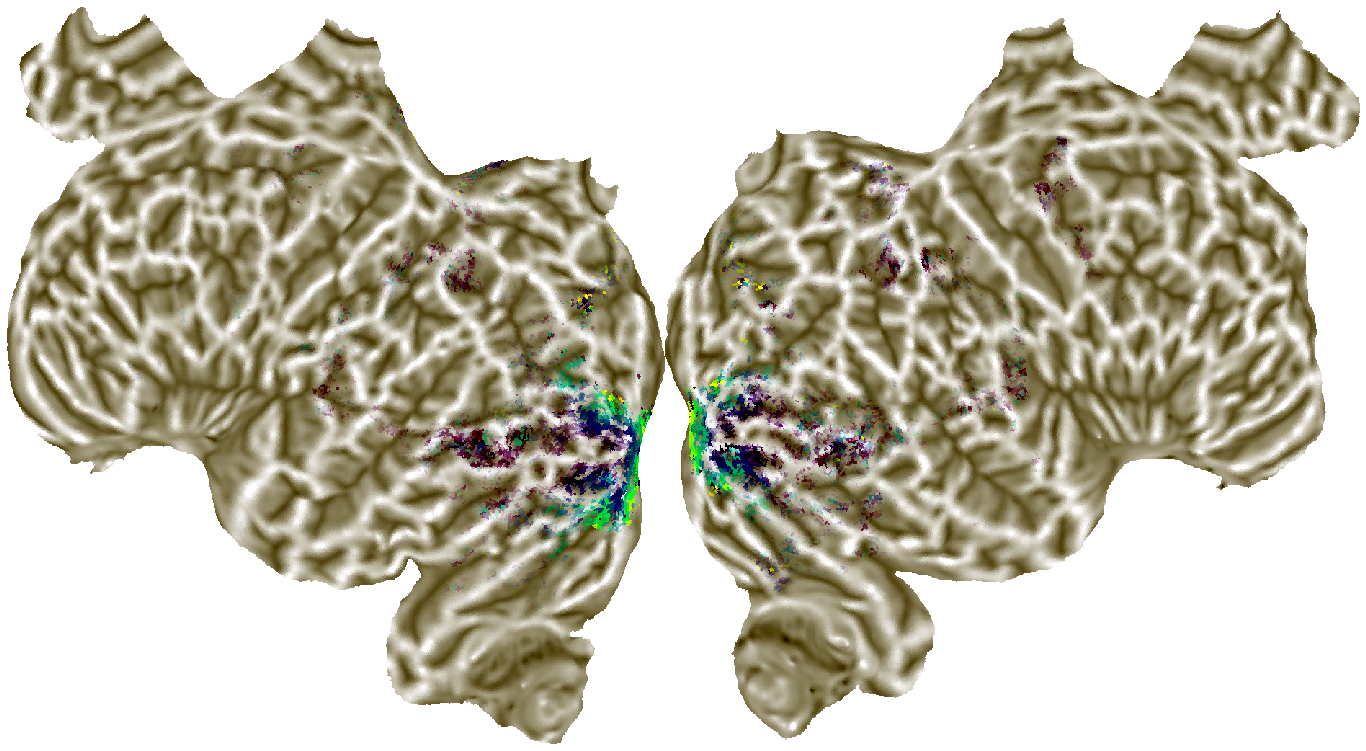

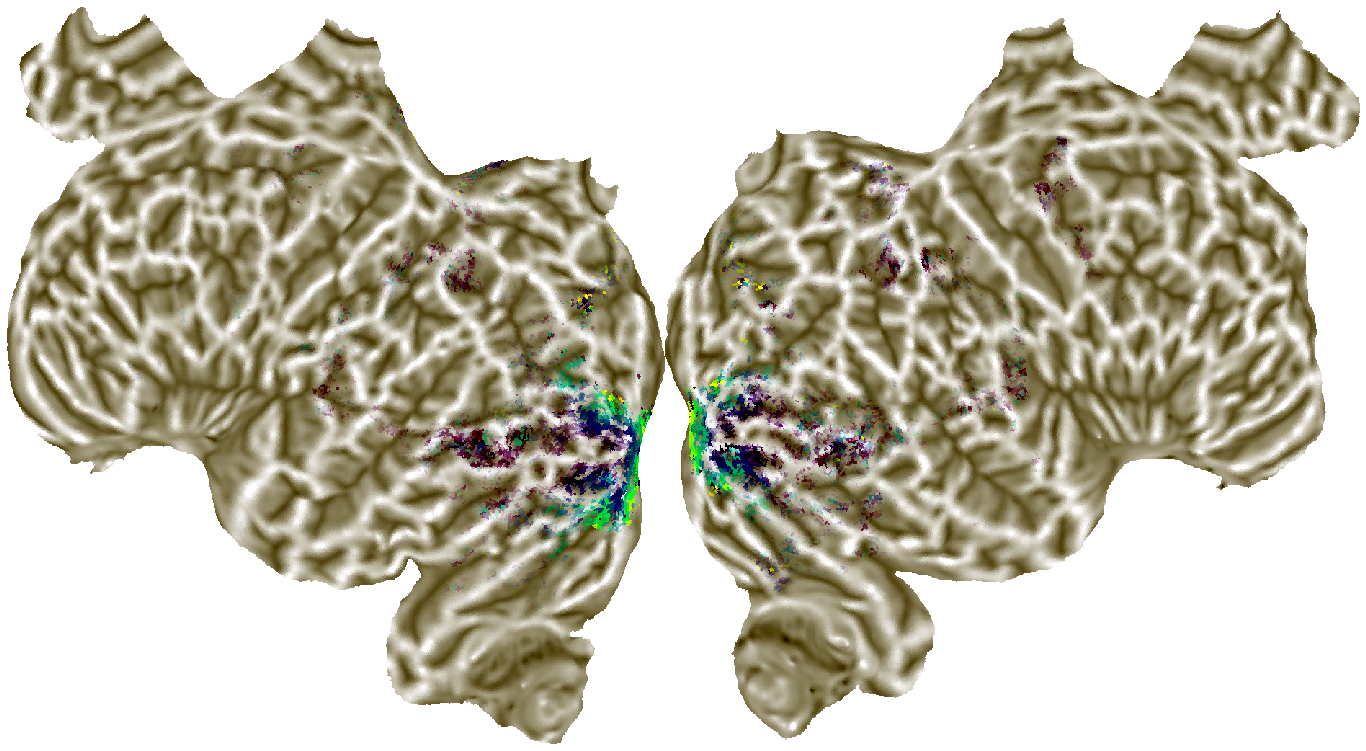

In [14]:
# Visualize the eccentricities on the cortical surface
sub = "sub-003"

# Create cortex volumes for eccentricities and R2
volume = cortex.Volume(eccentricities_volume, sub, "AOT1pt7mm", recache=True)
mapper = cortex.get_mapper(sub, "AOT1pt7mm", type="nearest", recache=True)
native_surface_map = mapper(volume)

volume_R2 = cortex.Volume(R2_data, sub, "AOT1pt7mm", recache=True)
mapper_R2 = cortex.get_mapper(sub, "AOT1pt7mm", type="nearest", recache=True)
native_surface_map_R2 = mapper_R2(volume_R2)

# Find max and min eccentricities for color scaling
max_ecc = np.nanmax(native_surface_map.data)
min_ecc = np.nanmin(native_surface_map.data)
print(f"Eccentricity range: {min_ecc} to {max_ecc}")

native_surface_map.vmin = min_ecc
native_surface_map.vmax = max_ecc

# Create merged map with R2 as opacity
merged_map = Vertex2D_fix(
    native_surface_map.data,
    native_surface_map_R2.data,
    sub,
    cmap="viridis",  # Using viridis colormap for eccentricity
    vmin=min_ecc,
    vmax=max_ecc,
    vmin2=0,
    vmax2=0.3,  # R2 threshold for opacity
)

# Set colormap for surface map
native_surface_map.cmap = "viridis"

# Display the merged map
cortex.quickshow(
    merged_map,
    with_curvature=False,
    with_colorbar=False,
    with_labels=False,
    with_sulci=True,
    with_legend=False,
    cmap="viridis",
    colorbar_label="Eccentricity",
)

In [21]:
# Save native_surface_map
# 'sub' (string 'sub-003') is defined in the current cell
# 'save_path' is from cell dc1bfd77
filename = save_path / f"native_surface_map_MEeccentricity_{sub}.pkl"
import pickle
with open(filename, "wb") as f:
    pickle.dump(merged_map, f)

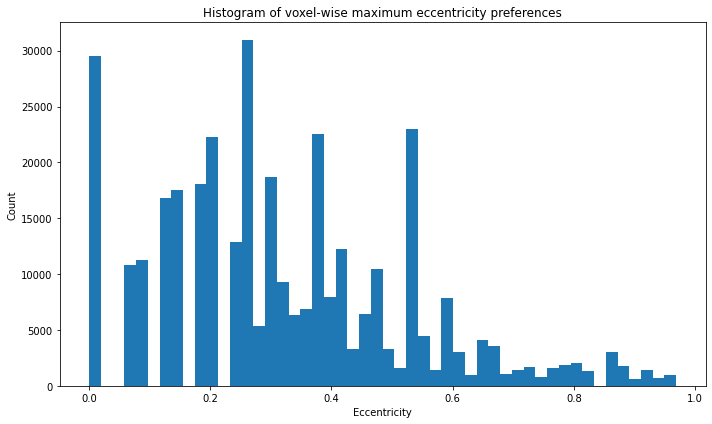

In [16]:
# Create a histogram of the eccentricities
plt.figure(figsize=(10, 6))
plt.hist(eccentricities, bins=50)
plt.xlabel('Eccentricity')
plt.ylabel('Count')
plt.title('Histogram of voxel-wise maximum eccentricity preferences')
plt.tight_layout()
plt.savefig(save_path / f"eccentricities_histogram_sub{sub}.png")
plt.show()